<a href="https://colab.research.google.com/github/vasanthmbandhu/myprojects/blob/main/robust_random_cut_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rrcf

  Created wheel for rrcf: filename=rrcf-0.4.3-cp36-none-any.whl size=9811 sha256=715ae1267a8f5cb447819618589b7025da64c0d0a996cfe641cc1f42c7d50a0e
  Stored in directory: /root/.cache/pip/wheels/6c/7c/b7/8983591821eb2c00a31795b29232dcedc4d7fad70a6c663870
Successfully built rrcf


In [2]:
import numpy as np
import rrcf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import files
files=files.upload()

Saving dec3.csv to dec3.csv


In [4]:
df = pd.read_csv('dec3.csv')

In [5]:
bandwidth = df['bandwidth(MBps)']
arr1 = bandwidth[4099:14099]
arr1 = arr1.dropna()

In [6]:
arr1 = arr1.to_numpy()
arr1 = arr1.reshape(-1, 1)
min_max_scaler = MinMaxScaler()
arr1 = min_max_scaler.fit_transform(arr1)
arr1 = arr1.reshape(-1,1)

In [7]:
bandwidth = pd.DataFrame(data = arr1)

In [8]:
bandwidth['time'] = df['time']

In [9]:
# Set tree parameters
num_trees = 100
shingle_size = 1
tree_size = 128


# Create a forest of empty trees
forest = []
for _ in range(num_trees):
    tree = rrcf.RCTree()
    forest.append(tree)

# Create a dict to store anomaly score of each point
avg_codisp = {}
    
# Use the "shingle" generator to create rolling window
points = rrcf.shingle(arr1, size=shingle_size)

# For each shingle...
for index, point in enumerate(points):
    # For each tree in the forest...
    for tree in forest:
        # If tree is above permitted size, drop the oldest point (FIFO)
        if len(tree.leaves) > tree_size:
            tree.forget_point(index - tree_size)
        # Insert the new point into the tree
        tree.insert_point(point, index=index)
        # Compute codisp on the new point and take the average among all trees
        if not index in avg_codisp:
            avg_codisp[index] = 0
        avg_codisp[index] += tree.codisp(index) / num_trees

In [10]:
df1 = pd.DataFrame.from_dict(avg_codisp,orient ='index')
df1.quantile(0.98)

0    22.203016
Name: 0.98, dtype: float64

In [11]:
bandwidth['CoDisp']= df1
bandwidth.head()

,0,time,CoDisp
0,0.977539,2020-11-17T21:02:59.779413Z,0.00
1,0.991937,2020-11-17T21:03:00.255132Z,1.00
2,0.990750,2020-11-17T21:03:00.918231Z,1.00
3,0.990553,2020-11-17T21:03:01.157192Z,1.00
4,0.992334,2020-11-17T21:03:37.939351Z,1.55


In [12]:
list1 = bandwidth['CoDisp']>25
bandwidth['Anomaly']=list1
bandwidth.head()

,0,time,CoDisp,Anomaly
0,0.977539,2020-11-17T21:02:59.779413Z,0.00,False
1,0.991937,2020-11-17T21:03:00.255132Z,1.00,False
2,0.990750,2020-11-17T21:03:00.918231Z,1.00,False
3,0.990553,2020-11-17T21:03:01.157192Z,1.00,False
4,0.992334,2020-11-17T21:03:37.939351Z,1.55,False


In [13]:
bandwidth.columns = ['bandwidth(MBps)','Time','CoDisp','Anomaly']

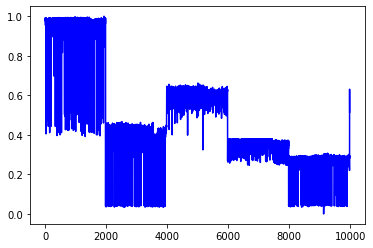

In [14]:
import matplotlib.pyplot as plt
a = np.arange(0,len(bandwidth))
plt.plot(a,bandwidth['bandwidth(MBps)'],'b')

In [15]:
anomaly={}
for index, row in bandwidth.iterrows():
  if row['Anomaly'] == True:
    anomaly[index] = row['bandwidth(MBps)']

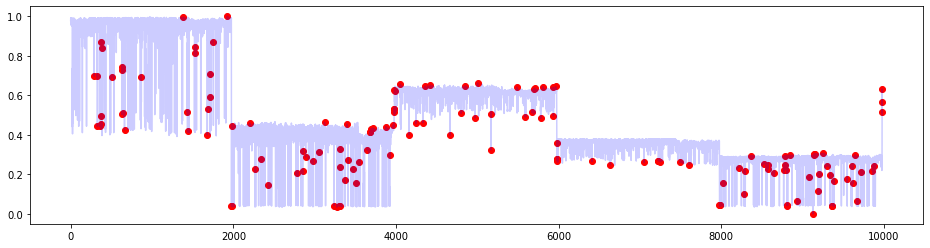

In [16]:
plt.figure(figsize=(16,4))
plt.plot(a,bandwidth['bandwidth(MBps)'],'b',alpha=0.2)
for key in anomaly:
    plt.scatter(key, anomaly[key],color='red')


In [17]:
#bandwidth.to_csv('bandwidth.csv')
#from google.colab import files
#files.download("bandwidth.csv")

In [18]:
df['time'] = pd.to_datetime(df['time'])
df.head()

,name,time,bandwidth(MBps),env,env_1,exp_instances,fail_count,host_ip,host_ip_address,instance,instance_id,instances,iteration_count,iteration_result,scale_type,sequence,size(MB),sla-action,sla-min_bandwidth,status,task_id,test_case_name,test_name,test_result,test_start_timestamp,url_per_instance
0,cp_test_tc012,2020-11-17 21:02:59.779413+00:00,9154.90,Auto_DUTProfile_Vsphere_34_81,Auto_DUTProfile_Vsphere_34_81,4,1.0,10.39.34.238,10.39.34.92,4,4,4,1,0.0,Scaled,1,2.05078,monitor,10000.0,0,b539815b-187c-4b60-a151-5aa88fd8dce3,YTC012 Memory Bandwidth,YTC012 Memory Bandwidth,0,1.605646e+09,/d/ytc012-per-instance/?orgId=1&from=160564625...
1,cp_test_tc012,2020-11-17 21:03:00.255132+00:00,9081.71,Auto_DUTProfile_Vsphere_34_81,Auto_DUTProfile_Vsphere_34_81,4,1.0,10.39.34.238,10.39.35.15,1,1,4,1,0.0,Scaled,1,2.05078,monitor,10000.0,0,b539815b-187c-4b60-a151-5aa88fd8dce3,YTC012 Memory Bandwidth,YTC012 Memory Bandwidth,0,1.605646e+09,/d/ytc012-per-instance/?orgId=1&from=160564625...
2,cp_test_tc012,2020-11-17 21:03:00.918231+00:00,9119.25,Auto_DUTProfile_Vsphere_34_81,Auto_DUTProfile_Vsphere_34_81,4,1.0,10.39.34.238,10.39.32.97,3,3,4,1,0.0,Scaled,1,2.05078,monitor,10000.0,0,b539815b-187c-4b60-a151-5aa88fd8dce3,YTC012 Memory Bandwidth,YTC012 Memory Bandwidth,0,1.605646e+09,/d/ytc012-per-instance/?orgId=1&from=160564625...
3,cp_test_tc012,2020-11-17 21:03:01.157192+00:00,9112.63,Auto_DUTProfile_Vsphere_34_81,Auto_DUTProfile_Vsphere_34_81,4,1.0,10.39.34.238,10.39.34.40,2,2,4,1,0.0,Scaled,1,2.05078,monitor,10000.0,0,b539815b-187c-4b60-a151-5aa88fd8dce3,YTC012 Memory Bandwidth,YTC012 Memory Bandwidth,0,1.605646e+09,/d/ytc012-per-instance/?orgId=1&from=160564625...
4,cp_test_tc012,2020-11-17 21:03:37.939351+00:00,9157.46,Auto_DUTProfile_Vsphere_34_81,Auto_DUTProfile_Vsphere_34_81,4,2.0,10.39.34.238,10.39.34.92,4,4,4,2,0.0,Scaled,2,2.05078,monitor,10000.0,0,b539815b-187c-4b60-a151-5aa88fd8dce3,YTC012 Memory Bandwidth,YTC012 Memory Bandwidth,0,1.605646e+09,/d/ytc012-per-instance/?orgId=1&from=160564625...


In [19]:
test = df[(df['time'] > '2020-11-22 23:00:00') & (df['time'] < '2020-11-22 23:06:00')]

In [20]:
#test = df['bandwidth(MBps)'][-200:]

In [49]:
bw = test['bandwidth(MBps)']
bw = bw.dropna()
bw = bw.to_numpy()

In [50]:
len(bw)

217

In [51]:
codisp=[]
test_tree = rrcf.RCTree()
for i in range(len(arr1)):
  test_tree.insert_point(arr1[i],index=i)
  codisp.append(test_tree.codisp(i))


In [52]:
test_codisp=[]
for i in range(len(bw)):
  test_tree.insert_point(bw[i],index = i + len(arr1))
  test_codisp.append(test_tree.codisp(i+len(arr1)))

In [25]:
test_codisp1 = pd.DataFrame(data=test_codisp)
test_codisp1.quantile(0.95)

0    1663.366667
Name: 0.95, dtype: float64

In [53]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


mean,std=norm.fit(test_codisp)

In [54]:
print (mean,',', std)

492.58227416481435 , 1345.243182227871


In [55]:
anomaly={}
i=0
for num in test_codisp:
  if num>(mean+6*std):
    anomaly[i] = num
  i = i+1
anomaly

{0: 9980.0, 13: 9980.0, 22: 9983.0}

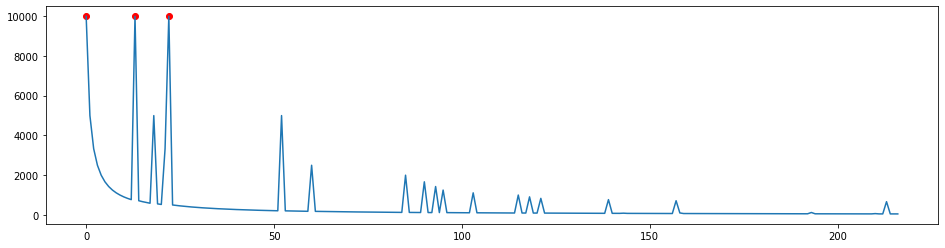

In [56]:
x = np.arange(len(bw))
plt.figure(figsize=(16,4))
plt.plot(x,test_codisp)
for key in anomaly:
    plt.scatter(key, anomaly[key],color='red')

In [65]:
mean,std=norm.fit(codisp)


In [ ]:
anomaly={}
i=0
for num in codisp:
  if num>(mean+6*std):
    anomaly[i] = num
  i = i+1
anomaly

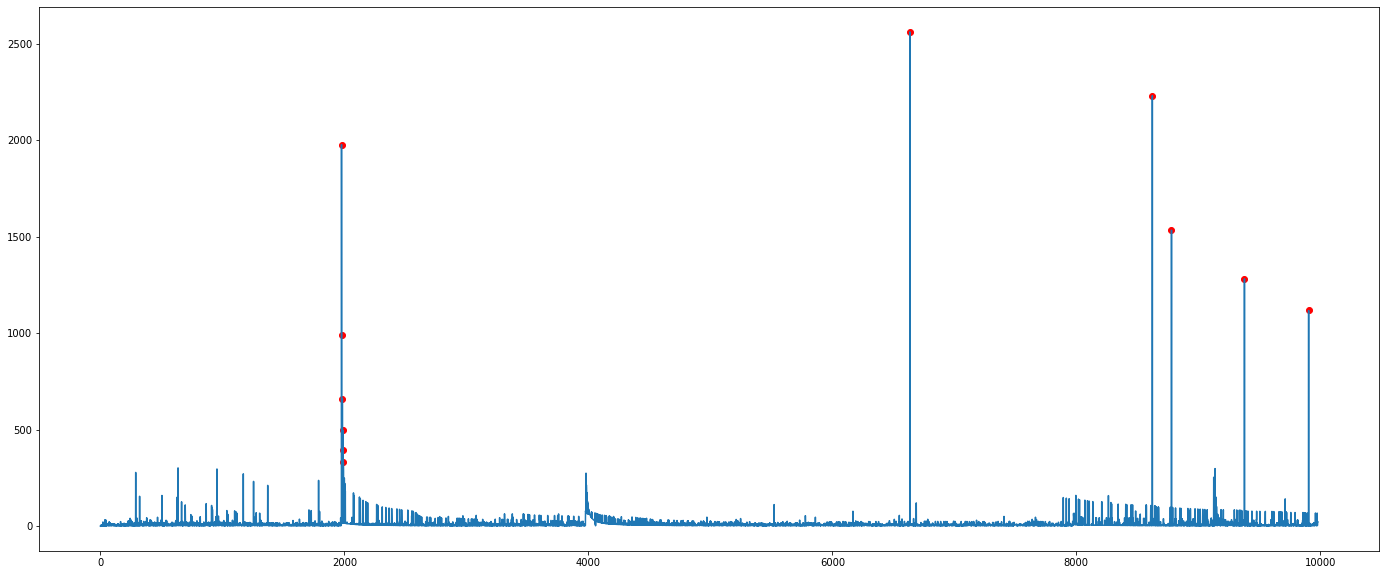

In [71]:
x = np.arange(len(codisp))
plt.figure(figsize=(24,10))
plt.plot(x,codisp)
for key in anomaly:
    plt.scatter(key, anomaly[key],color='red')